In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# ! pip install rs-datasets

# The notebook shows an example of recommendation for product categories with CatPopRec model
We will use movielens dataset and will consider genres as prodict categories. An item may belongs to several categories, but an interation is parametrized with one category. Assume the user select category at first and then select an item. CatPopRec calculates popularity of an item in categories and recommends the most popular items. 

Categories may be flat, but also may have structure of a tree. In this case we assume, that the category has only one parent and all items are mapped to only bottom-level (leaf) categories. CatPopRec allows to build recommendations not only for bottom level, but for any category, aggregating items' popularities in downstream categories.  
1. Data loading and reindexing
2. Categories preprocessing
3. Assigning categories to interactions
4. Recommending in case of flat categories structure
6. Building categories tree
4. Recommending in case of tree categories structure

In [3]:
from pyspark.sql import Window
from pyspark.sql.functions import split
import pyspark.sql.functions as sf

from replay.data import Dataset, FeatureSchema, FeatureInfo, FeatureHint, FeatureType
from replay.preprocessing.label_encoder import LabelEncoder, LabelEncodingRule
from replay.models import CatPopRec
from replay.utils.session_handler import State
from replay.splitters import TimeSplitter
from replay.utils import get_log_info, convert2spark
from rs_datasets import MovieLens

In [4]:
spark = State().session
spark

23/11/08 22:30:12 WARN Utils: Your hostname, ecs-eemalov-large resolves to a loopback address: 127.0.1.1; using 10.11.10.44 instead (on interface eth0)
23/11/08 22:30:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 22:30:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/08 22:30:13 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/11/08 22:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/08 22:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/11/08 22:

In [5]:
spark.sparkContext.setLogLevel('ERROR')

# 1. Data loading

We will use MovieLens 10m dataset from rs_datasets package, which contains a list of recommendations datasets.

In [6]:
data = MovieLens("10m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392



items


,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance



tags


,user_id,item_id,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867


### 1.1 Convert interaction log to RePlay format

In [7]:
%%time
interactions = convert2spark(data.ratings)
item_features = convert2spark(data.items)

CPU times: user 78 ms, sys: 129 ms, total: 207 ms
Wall time: 1.64 s


In [8]:
interactions.show(5)

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|      1|    122|   5.0|838985046|
|      1|    185|   5.0|838983525|
|      1|    231|   5.0|838983392|
|      1|    292|   5.0|838983421|
|      1|    316|   5.0|838983392|
+-------+-------+------+---------+
only showing top 5 rows



In [9]:
item_features.show(2)

+-------+----------------+--------------------+
|item_id|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
|      2|  Jumanji (1995)|Adventure|Childre...|
+-------+----------------+--------------------+
only showing top 2 rows



<a id='indexing'></a>
### 1.2. Indexing

Convert given users' and items' identifiers (\_id) to integers starting at zero without gaps (\_idx) with Indexer class.

In [10]:
user_encoder = LabelEncoder([LabelEncodingRule("user_id")])
item_encoder = LabelEncoder([LabelEncodingRule("item_id")])

In [11]:
%%time
user_encoder.fit(interactions)
item_encoder.fit(interactions.select('item_id').union(item_features.select('item_id')))

CPU times: user 399 ms, sys: 25.8 ms, total: 425 ms
Wall time: 5 s


In [12]:
%%time
log_replay = user_encoder.transform(df=interactions)
log_replay = item_encoder.transform(df=log_replay)
log_replay.show(2)

+------+---------+-------+-------+
|rating|timestamp|user_id|item_id|
+------+---------+-------+-------+
|   5.0|838985046|  27764|   5178|
|   5.0|838983525|  27764|   4962|
+------+---------+-------+-------+
only showing top 2 rows

CPU times: user 888 ms, sys: 6.62 ms, total: 894 ms
Wall time: 4.88 s


In [13]:
%%time
item_features_replay = item_encoder.transform(df=item_features)
item_features_replay.show(2)

+--------------------+--------------------+-------+
|               title|              genres|item_id|
+--------------------+--------------------+-------+
|Grumpier Old Men ...|      Comedy|Romance|    692|
|      Jumanji (1995)|Adventure|Childre...|   1349|
+--------------------+--------------------+-------+
only showing top 2 rows

CPU times: user 118 ms, sys: 3.13 ms, total: 121 ms
Wall time: 548 ms


### 1.3. Data split

In [14]:
# train/test split 
train_spl = TimeSplitter(
    time_threshold=0.2,
    drop_cold_items=True,
    drop_cold_users=True,
    query_column="user_id",

)
train, test = train_spl.split(log_replay)
print('train info:\n', get_log_info(train, user_col='user_id', item_col='item_id'))
print('test info:\n', get_log_info(test, user_col='user_id', item_col='item_id'))

train info:
 total lines: 8000043, total users: 59522, total items: 8989


test info:
 total lines: 249418, total users: 3196, total items: 8180


In [15]:
train.is_cached

False

# 2. Categories preprocessing

We will treat film genre as an item categories. 

In [16]:
genres = (
    item_features_replay
    .select(
        "item_id",
        split("genres", "\|").alias("genres")
    )
)

In [17]:
genres.show(5)

+-------+--------------------+
|item_id|              genres|
+-------+--------------------+
|    692|   [Comedy, Romance]|
|   1349|[Adventure, Child...|
|   6814|[Comedy, Drama, R...|
|   5659|[Action, Crime, T...|
|   4274|[Adventure, Anima...|
+-------+--------------------+
only showing top 5 rows



<AxesSubplot:>

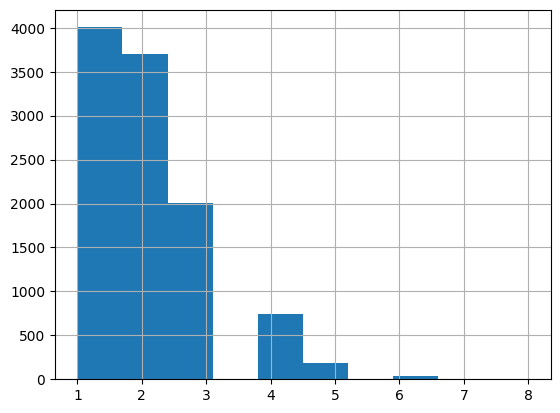

In [18]:
num_genres = genres.select("item_id", sf.size("genres").alias("num_genres"))
num_genres.toPandas()["num_genres"].hist(bins=10)

Some films have more than one genre. To model the real life we will randomly sample one category (genre) the item is chosen from for each interaction.

Will asign a number of each genre for each item and sample random integer from interval [0, num_genres) to get a category of an interaction.

In [19]:
genres = (genres
          .select("item_id", sf.explode("genres").alias("genre"))
          .withColumn("genre_number", sf.row_number().over(Window.orderBy("genre").partitionBy("item_id"))  - sf.lit(1)
                     )
         )
genres.show(5)

+-------+-------+------------+
|item_id|  genre|genre_number|
+-------+-------+------------+
|      0|  Drama|           0|
|      0|Romance|           1|
|      1|  Drama|           0|
|      1|Mystery|           1|
|      1|Romance|           2|
+-------+-------+------------+
only showing top 5 rows



Some films has several genres. Assume that each interaction with film is associated with a genre, e.g. the user select genre at first and then select film.
Lets build the interactions dataset based on this assumption. 

# 3. Assigning categories to interactions

In [20]:
train_genre = train.join(num_genres, on="item_id")
train_genre = train_genre.withColumn("genre_number", sf.floor(sf.rand() * sf.col("num_genres")).alias("category")).select("item_id", "user_id", "genre_number")
train_genre = train_genre.join(genres.withColumnRenamed("genre", "category"), on=["item_id", "genre_number"]).drop("genre_number")
train_genre.cache()
train_genre.count()

8000043

In [21]:
train_genre.groupBy("item_id", "category").agg(sf.count("category")).orderBy("item_id").show(5)

+-------+--------+---------------+
|item_id|category|count(category)|
+-------+--------+---------------+
|      0|   Drama|           3424|
|      0| Romance|           3456|
|      1| Romance|           1981|
|      1|   Drama|           2004|
|      1| Mystery|           1880|
+-------+--------+---------------+
only showing top 5 rows



In [22]:
train_genre.sample(0.0001).show(5)

+-------+-------+---------+
|item_id|user_id| category|
+-------+-------+---------+
|    243|  28939|   Action|
|   2493|   2268| Thriller|
|   2946|  37421|Adventure|
|   3636|  51779| Thriller|
|   4060|  57959|   Comedy|
+-------+-------+---------+
only showing top 5 rows



## Prepare Dataset

In [23]:
feature_schema = FeatureSchema(
    [
        FeatureInfo(
            column="user_id",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.QUERY_ID,
        ),
        FeatureInfo(
            column="item_id",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        ),
        FeatureInfo(
            column="category",
            feature_type=FeatureType.CATEGORICAL,
        ),
    ]
)

train_dataset = Dataset(
    feature_schema=feature_schema,
    interactions=train_genre,
)

# 4. Recommending in case of flat categories structure

## Building category structure

In [24]:
flat_cats = genres.select("genre").distinct().withColumnRenamed("genre", "category").withColumn("parent_cat", sf.lit(None)).cache()
flat_cats.show()

+------------------+----------+
|          category|parent_cat|
+------------------+----------+
|       Documentary|      null|
|           Fantasy|      null|
|              IMAX|      null|
|         Adventure|      null|
|               War|      null|
|         Animation|      null|
|            Comedy|      null|
|          Thriller|      null|
|         Film-Noir|      null|
|             Crime|      null|
|            Sci-Fi|      null|
|           Musical|      null|
|           Mystery|      null|
|             Drama|      null|
|            Horror|      null|
|           Western|      null|
|           Romance|      null|
|          Children|      null|
|            Action|      null|
|(no genres listed)|      null|
+------------------+----------+



## Model training

In [25]:
model = CatPopRec(flat_cats)

In [26]:
%%time
model.fit(train_dataset)

CPU times: user 9.36 ms, sys: 520 µs, total: 9.88 ms
Wall time: 505 ms


The model stores number of interactions with each item in each leaf category.

In [27]:
model.cat_item_popularity.orderBy(sf.col("category"), sf.col("relevance").desc()).show(5)

+------------------+-------+---------+
|          category|item_id|relevance|
+------------------+-------+---------+
|(no genres listed)|   7621|        2|
|            Action|   9399|    12314|
|            Action|   9621|     8602|
|            Action|   9815|     8005|
|            Action|   1124|     7979|
+------------------+-------+---------+
only showing top 5 rows



## Generating recommendations

In [28]:
%%time
pred = model.predict(["Action"], k=5)
(pred
 .join(item_features_replay, on="item_id")
 .orderBy(sf.col("relevance").desc())
 .select("category", "item_id", sf.round("relevance", 4).alias("relevance"), sf.substring("title", 0, 40), "genres")
).show(5, truncate=False)

+--------+-------+---------+----------------------------------------+-----------------------+
|category|item_id|relevance|substring(title, 0, 40)                 |genres                 |
+--------+-------+---------+----------------------------------------+-----------------------+
|Action  |9399   |0.0168   |Terminator 2: Judgment Day (1991)       |Action|Sci-Fi          |
|Action  |9621   |0.0117   |Raiders of the Lost Ark (Indiana Jones a|Action|Adventure       |
|Action  |9815   |0.0109   |Braveheart (1995)                       |Action|Drama|War       |
|Action  |1124   |0.0109   |Star Wars: Episode IV - A New Hope (a.k.|Action|Adventure|Sci-Fi|
|Action  |4964   |0.0093   |Star Wars: Episode VI - Return of the Je|Action|Adventure|Sci-Fi|
+--------+-------+---------+----------------------------------------+-----------------------+

CPU times: user 36.7 ms, sys: 20.4 ms, total: 57 ms
Wall time: 2.77 s


# 5. Recommending in case of tree categories structure

## Building category structure

Let's create three parent categories and assing a parent for each genre.

In [29]:
parent_cats = spark.createDataFrame([("Dark", None), ("Bright", None), ("Neutral", None)], schema="category string, parent_cat string")

In [30]:
parent_cats.show()

+--------+----------+
|category|parent_cat|
+--------+----------+
|    Dark|      null|
|  Bright|      null|
| Neutral|      null|
+--------+----------+



In [31]:
cat_tree = (flat_cats
            .withColumn("parent_cat", 
                        sf.when(sf.col("category").isin(["Romance", "Comedy"]), "Bright")
                        .otherwise(
                            sf.when(sf.col("category").isin(["Drama", "Horror", "War", "Thriller", "Film-Noir"]), "Dark")
                            .otherwise("Neutral"))
                       )
           .unionByName(parent_cats)
           )
cat_tree.show()

+------------------+----------+
|          category|parent_cat|
+------------------+----------+
|       Documentary|   Neutral|
|           Fantasy|   Neutral|
|              IMAX|   Neutral|
|         Adventure|   Neutral|
|               War|      Dark|
|         Animation|   Neutral|
|            Comedy|    Bright|
|          Thriller|      Dark|
|         Film-Noir|      Dark|
|             Crime|   Neutral|
|            Sci-Fi|   Neutral|
|           Musical|   Neutral|
|           Mystery|   Neutral|
|             Drama|      Dark|
|            Horror|      Dark|
|           Western|   Neutral|
|           Romance|    Bright|
|          Children|   Neutral|
|            Action|   Neutral|
|(no genres listed)|   Neutral|
+------------------+----------+
only showing top 20 rows



## Model training

In [32]:
model = CatPopRec(cat_tree)

In [33]:
%%time
model.fit(train_dataset)

CPU times: user 3.34 ms, sys: 1.74 ms, total: 5.08 ms
Wall time: 85.6 ms


The model stores number of interactions with each item in each leaf category.

In [34]:
model.cat_item_popularity.orderBy(sf.col("category"), sf.col("relevance").desc()).show(5)

+------------------+-------+---------+
|          category|item_id|relevance|
+------------------+-------+---------+
|(no genres listed)|   7621|        2|
|            Action|   9399|    12314|
|            Action|   9621|     8602|
|            Action|   9815|     8005|
|            Action|   1124|     7979|
+------------------+-------+---------+
only showing top 5 rows



## Generating recommendations

In [35]:
pred.unpersist()

DataFrame[category: string, item_id: bigint, relevance: double]

In [36]:
%%time
pred = model.predict(["Bright", "Romance", "Comedy"], k=5)
(pred
 .join(item_features_replay, on="item_id")
 .orderBy(sf.col("category"), sf.col("relevance").desc())
 .select("category", "item_id", "relevance", "title", "genres")
).show(truncate=False)

+--------+-------+--------------------+--------------------------------------+------------------------+
|category|item_id|relevance           |title                                 |genres                  |
+--------+-------+--------------------+--------------------------------------+------------------------+
|Bright  |2021   |0.007996300880202234|Ace Ventura: Pet Detective (1994)     |Comedy                  |
|Bright  |3825   |0.007493301805905117|Pretty Woman (1990)                   |Comedy|Romance          |
|Bright  |241    |0.006798332442701945|Four Weddings and a Funeral (1994)    |Comedy|Romance          |
|Bright  |3822   |0.006763260947613339|Dumb & Dumber (1994)                  |Comedy                  |
|Bright  |661    |0.006537603564740596|Forrest Gump (1994)                   |Comedy|Drama|Romance|War|
|Comedy  |2021   |0.01093788169438695 |Ace Ventura: Pet Detective (1994)     |Comedy                  |
|Comedy  |3822   |0.009251246197653228|Dumb & Dumber (1994)     